## ECON 8320 Semester Project
### Troy Gilmore
### May 10, 2023

### Background
In July, 2021, the National Collegiate Athletic Association (NCAA) adopted a policy that allowed current and incoming NCAA college athletes to benefit from their name, image and likeness (NIL). Within a year, the total amount of NIL deals likely approached 1 billion$^{1}$ USD. As of February 2023, however, there appear to be no nationwide standards or requirements to disclose NIL information$^{2}$. In fact, several state legislatures have passed legislation that protects universities from media requests for NIL information. As a result, current NIL information draws from limited release of information from student athletes themselves, or their universities or sponsoring entities. This information is being compiled on websites such as https://nilcollegeathletes.com and https://www.on3.com/os/.

### Methods
For this semester project, I extracted and organized NIL information, including (1) athlete name, (2) school, (3) sport, (4) sponsorship, and (5) social media account information available from https://www.on3.com/nil/deals/. The primary methods used for this project were the Selenium 4 library, BeautifulSoup (bs4) library, Regular Expressions, NumPy and Pandas. 

Selenium is designed for automated testing of websites. In this project it was used because the on3.com database only shows about 25 athletes when initially loaded. To load information for additional athletes requires clicking a "LOAD MORE" button at the bottom of the page. Unlike our web scraping homework, there was no href that could be called to load more data. Therefore, Selenium was required to open a browser and activate the "LOAD MORE" button to load more data. For the final data set, this was done 200 times, resulting in approximately 5000 athlete listings loaded on the website.

Once the athlete listings were loaded, the html was parsed using BeautifulSoup. Visual inspection of the on3.com html tags and text was used to navigate the parsed file and extract athlete information. In some cases, Regular Expressions were used to locate and/or extract text. The extracted information was stored in lists, which were compiled into a summary Pandas dataframe and exported to a CSV file. Try and Except blocks were used to check whether information existed, and where it did not exist, a Pandas function was used to insert "nan" in place of the missing data. 

The athlete name, school, and sponsorship information was scraped from the main webpage (https://www.on3.com/nil/deals/). The URLs for individual player websites (discussed below) were also scraped and stored in the final dataframe. I chose to compile values for each variable in a separate column as I iterated through the available athlete descriptions. Since this meant iterating through athlete information blocks multiple times, there is a risk that an "nan" value or other artifact could result in values that were misaligned with the original row of player's name. Agreement with player names and other row elements was checked manually, but also confirmed by checking that all columns had the exact same length. The benefit of this approach, especially for the main webpage, was that I could build and test the code snippets independently and with fewer nested loops. This was still challenging but more logical to me based on current programming experience.

$^{1}$https://www.nbcnewyork.com/news/sports/one-year-of-nil-how-much-have-athletes-made/3765040/
$^{2}$https://splc.org/2023/02/everything-we-know-about-nil-law-policy-so-far/

In [265]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import re
import time
import random as rnd
import selenium #selenium 4
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.select import Select
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import csv

## Enter desired number of iterations below to scrape data

In [266]:
# This value controls how many times the "Load More" button is used to expand the dataset.
# Expect approximately 25*(iterations + 1) results.
iterations = 2

In [267]:
# initiate Selenium
service = ChromeService(executable_path=ChromeDriverManager().install())
opts = Options()
# opt to add user agent
opts.add_argument("user-agent=[user-agent string]")
# opt to run browser in incognito mode
opts.add_argument('--incognito')
# opt to not open the browser (commented out, but kept here as an option)
# opts.add_argument('--headless')
# create an object of the chrome webdriver
driver = webdriver.Chrome(options=opts, service=service)

# load target URL
driver.get("https://www.on3.com/nil/deals/")
# select and click button to load more data
button = "NilDealTracker_btnLoadMore__CitAb"
click = driver.find_element(By.CLASS_NAME, button)
# set number of times to click "load more"
# each page has about 25 athlete listings
# range(100) will yield about 2500 listings
indexList = range(iterations) # set to a small number for demonstration purposes
for i in indexList:
    try:
        time.sleep(3) # delay 3 seconds to allow page to load
        driver.execute_script("arguments[0].click();", click)
        # delay additional 3 seconds
        # (maybe not necessary, but added anyway)
        time.sleep(3)
    finally:
        print("Load More Data #",i)
# hand off Selenium output to BeautifulSoup
page_source = driver.page_source
# parse webpage html
parsed = bs(page_source, 'html.parser')

# write parsed html to an html file for later use
html = parsed.prettify("utf-8")
with open("Project_Gilmore_6.html", "wb") as file:
    file.write(html)

# ===============================================
# ============ Get athlete's info ===============
# ===============================================
# create empty lists
player = []
schoolTransfer = []
schoolCommit = []
schoolUndecided = []
collective = []
client = []
position = []
playerURL = []

# scrape all containers in list of player information
playerContainers = parsed.find_all("li", class_="DealTrackerItem_container__yWF2E")
for name in playerContainers:
    # ========= Get athlete's name ==================
    try:
        filbert = "MuiTypography-root MuiLink-root MuiLink-underlineNone MuiTypography-h5 MuiTypography-colorPrimary"
        player1 = name.find('a', class_=filbert)
        playerNameText = player1.text
        player.append(playerNameText)
    except:
        player.append(np.nan)
    # ========= Get athlete's school(s)==============
    # collect transfer information if it exists
    try:
        transfer = "PlayerDealItem_transferredAssetContainer__LqORX"
        school1 = name.find("div", class_= transfer)
        imageClass = "PlayerDealItem_transferredAssetLogo__cX4S_"
        school2 = school1.find(class_= imageClass)
        playerSchoolText = school2['title']
        schoolTransfer.append(playerSchoolText)
    # append "nan" if transfer information does not exist
    except:
        schoolTransfer.append(np.nan)
    # collect commit information if it exists        
    try:
        commit = "PlayerDealItem_committedAssetContainer__1eBOw"
        school1 = name.find("div", class_= commit)
        imageClass = "PlayerDealItem_committedAssetLogo__4IX6_"
        school2 = school1.find(class_= imageClass)
        playerSchoolText = school2['title']
        schoolCommit.append(playerSchoolText)
    except:
        schoolCommit.append(np.nan)
    # collect undecided information if it exists        
    try:
        undecided = "PlayerDealItem_undecidedContainer__EtVXO"
        undecided1 = name.find("div", class_= undecided)
        undecided_h6 = "MuiTypography-root MuiTypography-subtitle1 MuiTypography-colorTextPrimary"
        undecided2 = name.find(class_= undecided_h6)
        playerSchoolText = undecided2.text
        schoolUndecided.append(playerSchoolText)
    # append "nan" if undecided information does not exist
    except:
        schoolUndecided.append(np.nan)
    # ========= Get collective/client ===============
    # collect information on collective if it exists
    try:
        coll = "MuiTypography-root MuiLink-root MuiLink-underlineNone DealTrackerItem_collectiveLink__DgG6Z MuiTypography-caption MuiTypography-colorPrimary"
        collect = name.find("a", class_=coll)
        collect = collect.text
        collective.append(collect)
    # append "nan" if collective information does not exist
    except:
        collective.append(np.nan)
    # collect information on client (sponsoring company) if it exists
    try:
        cli = name.find(class_="MuiTypography-root MuiTypography-h5 MuiTypography-colorTextPrimary")
        cli = cli.text
        client.append(cli)
    # append "nan" if client information does not exist
    except:
        client.append(np.nan)
    # =========== Get position info =================
    try:
        pos = "PlayerDealItem_playerVitalsContainer__rj32S"
        position1 = name.find("span", 'aria-label'=="Position")
        position2 = position1.text
        position.append(position2)
    except:
        position.append(np.nan)

    # =========== Get URL for Player ================
    try:
        pURL = "PlayerDealItem_playerName__K5EXe" #step into parent
        playerURL1 = name.find("div", class_= pURL)
        # step into class that contains href
        playerURL_a = "MuiTypography-root MuiLink-root MuiLink-underlineNone MuiTypography-h5 MuiTypography-colorPrimary"
        playerURL2 = name.find("a", class_= playerURL_a).get('href')
        playerURLText = f"https://www.on3.com{playerURL2}"
#        playerURLLink = "=HYPERLINK("https://www.on3.com" + playerURL2")"
        # check whether URL ends in "nil/
        if bool(re.search(r'(nil\/$)', playerURLText)) != True:
            # if not, add "nil/" to end of string
            playerURLText = f"{playerURLText}nil/"
#        print(playerURLText)
        playerURL.append(playerURLText)
    # if no URL exists, append string "NO URL"
    except:
        playerURL.append("NO URL")

# ==================================================
# ========== Assemble dataframe ====================
# ==================================================
try:
    print("Length of lists:", len(player), len(schoolTransfer), len(schoolCommit), len(schoolUndecided), len(client), len(collective), len(position))
    summary = pd.DataFrame(player, columns = ['player'])
    summary['transfer'] = schoolTransfer
    summary['commit'] = schoolCommit
    summary['undecided'] = schoolUndecided
    summary['client'] = client
    summary['collective'] = collective
    summary['position'] = position
    summary['URL'] = playerURL
    filename = "NIL Summary_first page.csv"
    summary.to_csv(filename)
# Provide diagnostics if dataframe cannot be created
except:
    print(len(player), len(schoolTransfer), len(schoolCommit), len(schoolUndecided), len(client), len(collective), len(position))
    print("Could not create final dataframe - check column lengths or whether .csv file is open!")


Load More Data # 0
Load More Data # 1
Length of lists: 75 75 75 75 75 75 75


### Methods, continued
The sport and social media account information was scraped from individual player websites (e.g., https://www.on3.com/db/davin-vann-32272/nil/). These URLs were not consistent (some ended in "/nil/" and some did not), so a routine was written to check for "/nil/" and add those five characters at the end of the string if needed. The first step in the scraping process was completed by iterating through the list of player URLs, parsing each one and scraping relevant information using BeautifulSoup. Social media accounts varied by athlete, with some having TikTok, Instagram, and Twitter, and others having no social media or only 1-2 accounts. To account for this variation in social media information, a nested set of try-except blocks were used to navigate the parsed html, check whether or not an account existed and either scrape the information or insert "nan" where needed. The sport information is the least robust among any athlete variables compiled in this project, as described in the Difficulties section below. 

In [268]:
# ==================================================
# ========== Get Social Media Info =================
# ==================================================
# create empty lists
twitterURL = []
instagramURL = []
tiktokURL = []
sport = []

# loop through list of player URLs created from main webpage
for URL in playerURL:
    # load and parse player information page
    try:
        URLPage = requests.get(URL, 'html.parser')
        URLparsed = bs(URLPage.text)
        # look in wrapper for player valuation
        # rank of athlete includes information on athlete's sport
        try:
            pSport = "NilSocialValuations_totalValuationWrapper__xEhcs"
            playerSportBlock = URLparsed.find_all("div", class_= pSport)
            # scrape text from first second element of playerSportBlock
            playerSport = playerSportBlock[1].text
            sport.append(playerSport)
        # if sport information does not exist, append "nan"
        except:
            sport.append(np.nan)
        # now access block containing social media information
        try:
            pSoc = "PlayerNIL_socialPostsBlock__mIktq"
            playerSocialBlock = URLparsed.find("div", class_= pSoc)
            # diagnostic text
            # print(len(playerSocialBlock))
            # find all social media URLs
            try:
                playerSocialURLs = playerSocialBlock.find_all('a', href=True)
                # regex to look in social media URLs for Twitter URL
                try:
                    twitterURLtemp = re.findall(r'(https\:\/\/twitter\.com\/\S+)', str(playerSocialURLs))
                    twitterURLtemp = twitterURLtemp[0]
                    # remove extraneous " from end of URL
                    twitterURLtemp = twitterURLtemp.rstrip(twitterURLtemp[-1])
                    # append to list of Twitter URLs
                    twitterURL.append(twitterURLtemp)
                    # diagnostic text
                    # print("There is Twitter AND we got a specific URL:", twitterURLtemp)
                    # if there is no Twitter URL, then append "nan"
                except:
                    twitterURL.append(np.nan)
                    # diagnostic text
                    # print("There is no Twitter")
                try:
                    # regex to look in social media URLs for TikTok URL
                    tiktokURLtemp = re.findall(r'(https\:\/\/www.tiktok.com\/\S+)', str(playerSocialURLs))
                    tiktokURLtemp = tiktokURLtemp[0]
                    # remove extraneous " from end of string
                    tiktokURLtemp = tiktokURLtemp.rstrip(tiktokURLtemp[-1])
                    # diagnostic text
                    # print("There is TikTok AND we got a specific URL:", tiktokURLtemp)
                    tiktokURL.append(tiktokURLtemp)
                except:
                    # if there is no TikTok URL, then append "nan" to list
                    tiktokURL.append(np.nan)
                    # diagnostic text
                    # print("There is no TikTok")
                try:
                    # use regex to look for Instagram URL
                    instagramURLtemp = re.findall(r'(https\:\/\/www.instagram.com\/\S+)', str(playerSocialURLs))
                    instagramURLtemp = instagramURLtemp[0]
                    # remove extraneous " from end of URL string
                    instagramURLtemp = instagramURLtemp.rstrip(instagramURLtemp[-1])
                    # append URL to Instagram list
                    instagramURL.append(instagramURLtemp)
                    # diagnostic text
                    # print("There is Instagram AND we got a specific URL:", instagramURLtemp)
                except:
                    # If there is no Instagram URL, append "nan"
                    # diagnostic text
                    # print("There is no Instagram")
                    instagramURL.append(np.nan)
            except:
                # if no sport or social URLs are found, 
                # append "nan" for all types of social
                print("No sport or social URLs")
                twitterURL.append(np.nan)
                instagramURL.append(np.nan)
                tiktokURL.append(np.nan)
                sport.append(np.nan)
        # if there is no social block, append "nan"
        # for all social and sport lists
        except:
            print("No social block.")
            twitterURL.append(np.nan)
            instagramURL.append(np.nan)
            tiktokURL.append(np.nan)
            sport.append(np.nan)
            # if there is no player URL, append "nan" to all
    except:
        print("No player URL.")
        twitterURL.append(np.nan)
        instagramURL.append(np.nan)
        tiktokURL.append(np.nan)
        sport.append(np.nan)
try:
# ADD SOCIAL MEDIA AND SPORT INFORMATION TO DATAFRAME
    summary['Twitter'] = twitterURL
    summary['TikTok'] = tiktokURL
    summary['Instagram'] = instagramURL
    summary['Sport'] = sport
    print(summary.columns)
# CREATE CSV FILE OF RESULTS
    filename = "NIL Summary_Jupyter Notebooks.csv"
    summary.to_csv(filename)
# CLOSE BROWSER THAT WAS OPENED BY SELENIUM
    driver.quit()
except:
# IF THERE IS AN EXCEPTION, PRINT LENGTHS AND WARNING FOR DIAGNOSTICS
    print(len(player), len(twitterURL), len(tiktokURL), len(instagramURL), len(sport))
    print("Could not create final dataframe - check column lengths or whether .csv file is open!")
# IF THERE IS AN EXCEPTION, CREATE INDIVIDUAL CSV FILES AS DIAGNOSTIC TOOLS
    twitter_df = pd.DataFrame(twitterURL, columns = ['Twitter'])
    twitter_df.to_csv("twittertemp.csv")
    tiktok_df = pd.DataFrame(tiktokURL, columns = ['Tiktok'])
    tiktok_df.to_csv("tiktoktemp.csv")
    instagram_df = pd.DataFrame(instagramURL, columns = ['Instagram'])
    instagram_df.to_csv("instagramtemp.csv")
    sport_df = pd.DataFrame(instagramURL, columns = ['sport'])
    instagram_df.to_csv("sporttemp.csv")
# CLOSE BROWSER THAT WAS OPENED BY SELENIUM
    driver.quit()

Index(['player', 'transfer', 'commit', 'undecided', 'client', 'collective',
       'position', 'URL', 'Twitter', 'TikTok', 'Instagram', 'Sport'],
      dtype='object')


### Difficulties
I was not able to find a stand-alone element on the main website or individual player websites that could easily identify the sport of the athlete. Instead, I attempted to scrape two pieces of information: (1) the position information (e.g., IOL for an interior offensive lineman in American football) from the main web page and (2) the athlete's valuation or social media ranking (which had text labels such as "College Women's Basketball") from the athlete web page. My resolution to this was to build a list of unique athlete positions included in the largest dataset I scraped, and then use a conditional statement to classify the sport of each athlete based on position information already recorded in the dataframe. The cell just below includes code to demonstrate how this was done. One significant limitation to this approach is that there are some positions that appear in more than one sport. For example, the following positions could be related to more than one sport:

<div>
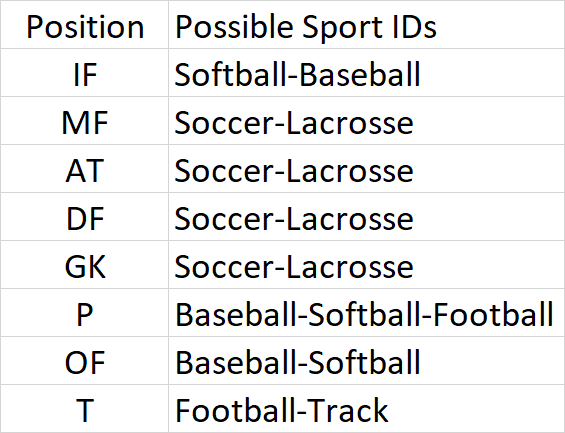
</div>

Additional challenges included differentiating between collectives (groups that help negotiate deals) and clients (actual athlete sponsors) and differentiating between undecided, transfer, and committed status for the schools that the athlete was associated with.

Lastly, the On3.com website is constantly being updated. Due to the length of time required to scrape information for a large number of players, I will use a static dataset (from a CSV file created by the code in the two large cells, above).

In [269]:
# load CSV file with sport identifiers based on position information
csvfile = "sport_identifier_dictionary.csv"
sport_ID = pd.read_csv(csvfile, dialect='excel', index_col=False)
try:
    # test length of unique sport ID list to see if new positions have appeared in the dataset
    position_df = summary['position']
    len(sport_ID['positionID']) == len(position_df.drop_duplicates())
    # create dictionary with keys = positionID and values = sport type
    sport_ID_dict = dict(zip(sport_ID.positionID, sport_ID.sport))
    # create new column in summary and fill in sport based on position information and dictionary entries
    summary['sportID'] = summary['position'].map(sport_ID_dict)
except:
    print("length of sport_ID.position", sport_ID.position)
    print("New positions exist - please update sport_identifier_dictionary.csv")
print(summary.columns)

Index(['player', 'transfer', 'commit', 'undecided', 'client', 'collective',
       'position', 'URL', 'Twitter', 'TikTok', 'Instagram', 'Sport',
       'sportID'],
      dtype='object')


### Results
Below is a table header showing the types of data scraped for this project. If the code sections above have been run recently, the player names shown here may be different than the players displayed from the static dataset that is loaded just below this table.

In [270]:
summary.head(5)

,player,transfer,commit,undecided,client,collective,position,URL,Twitter,TikTok,Instagram,Sport,sportID
0,Isaac Larsen,NaN,utah state aggies,NaN,Taco Time,NaN,S,https://www.on3.com/db/isaac-larsen-49197/nil/,NaN,NaN,NaN,NaN,Football
1,Temi Thomas-Ailara,NaN,northwestern wildcats,NaN,Chicago White Sox,NaN,OH,https://www.on3.com/db/temi-thomas-ailara-1805...,NaN,NaN,NaN,NaN,Volleyball
2,Cameron Williams,NaN,michigan wolverines,NaN,Chicago White Sox,NaN,PF,https://www.on3.com/db/cameron-williams-168783...,NaN,NaN,NaN,NaN,Basketball
3,Kylie Feuerbach,NaN,iowa hawkeyes,NaN,Chicago White Sox,NaN,SG,https://www.on3.com/db/kylie-feuerbach-168762/...,https://twitter.com/KylieFeuerbach,https://www.tiktok.com/@kyliefeuerbach,https://www.instagram.com/kyliefeuerbach/,College Women's Basketball NIL Rank#51,Basketball
4,Anaya Peoples,NaN,depaul blue demons,NaN,Chicago White Sox,NaN,SG,https://www.on3.com/db/anaya-peoples-168357/nil/,NaN,NaN,NaN,NaN,Basketball


### Exploration of data in static data file
The following data was scraped on May 9, 2023 at approximately 6pm. This static data set will be used to explore some basic characteristics of the dataset.

In [271]:
#dir = os.getcwd()
csvfile = "NIL Summary_200_JupyterNotebook.csv"
summary = pd.read_csv(csvfile, dialect='excel', index_col=0)
type(summary)
summary.head(10)

# load CSV file with sport identifiers based on position information
csvfile = "sport_identifier_dictionary.csv"
sport_ID = pd.read_csv(csvfile, dialect='excel', index_col=False)
try:
    # test length of unique sport ID list to see if new positions have appeared in the dataset
    position_df = summary['position']
    len(sport_ID['positionID']) == len(position_df.drop_duplicates())
    # create dictionary with keys = positionID and values = sport type
    sport_ID_dict = dict(zip(sport_ID.positionID, sport_ID.sport))
    # create new column in summary and fill in sport based on position information and dictionary entries
    summary['sportID'] = summary['position'].map(sport_ID_dict)
except:
    print("length of sport_ID.position", sport_ID.position)
    print("New positions exist - please update sport_identifier_dictionary.csv")
print(summary.columns)

# ========= SUMMARIZE COLLECTED DATA ===================================
# DETERMINE NUMBER OF PLAYERS AND HOW MANY EACH
playerSummarySize = summary.value_counts("player")
PlayerCounts = playerSummarySize.describe()
# DETERMINE NUMBER OF COLLECTIVES AND HOW MANY EACH
collectiveSummarySize = summary.value_counts("collective")
CollectiveCounts = collectiveSummarySize.describe()
# DETERMINE NUMBER OF CLIENTS AND HOW MANY EACH
clientSummarySize = summary.value_counts("client")
ClientCounts = clientSummarySize.describe()
# DETERMINE NUMBER OF SCHOOLS AND HOW MANY EACH
schoolSummarySize = summary.value_counts("commit")
SchoolCounts = schoolSummarySize.describe()
# DETERMINE NUMBER OF TWITTER AND HOW MANY EACH
TwitterSummarySize = summary.value_counts("Twitter")
TwitterCounts = TwitterSummarySize.describe()
# DETERMINE NUMBER OF TIKTOK AND HOW MANY EACH
TikTokSummarySize = summary.value_counts("TikTok")
TikTokCounts = TikTokSummarySize.describe()
# DETERMINE NUMBER OF INSTAGRAM AND HOW MANY EACH
InstagramSummarySize = summary.value_counts("Instagram")
InstagramCounts = InstagramSummarySize.describe()
# DETERMINE NUMBER OF SPORTS AND HOW MANY EACH
SportIDSummarySize = summary.value_counts("sportID")
SportIDCounts = SportIDSummarySize.describe()

summary.apply(np.count_nonzero)

summaryCountTable = pd.concat([PlayerCounts, CollectiveCounts, ClientCounts,
                               SchoolCounts, SportIDCounts, TwitterCounts, TikTokCounts,
                               InstagramCounts], axis = 1)
summaryCountTable.columns = ["Players", "Collectives", "Clients", "Schools (Committed)", "Sports", "Twitter", "TikTok", "Instagram"]
summaryCountTable = summaryCountTable.round(1)
summaryCountTable

Index(['player', 'transfer', 'commit', 'undecided', 'client', 'collective',
       'position', 'URL', 'Twitter', 'TikTok', 'Instagram', 'Sport',
       'sportID'],
      dtype='object')


,Players,Collectives,Clients,Schools (Committed),Sports,Twitter,TikTok,Instagram
count,2972.0,121.0,1280.0,203.0,11.0,2442.0,1290.0,2401.0
mean,1.7,17.4,2.6,20.5,456.2,1.8,2.1,1.8
std,1.7,17.9,4.8,29.5,889.0,1.8,2.3,1.9
min,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0
25%,1.0,4.0,1.0,1.5,40.0,1.0,1.0,1.0
50%,1.0,12.0,1.0,4.0,70.0,1.0,1.0,1.0
75%,2.0,24.0,2.0,30.5,154.5,2.0,2.0,2.0
max,24.0,88.0,108.0,143.0,2698.0,24.0,32.0,24.0


### Count Summary of Key Variables

There were 5,018 athlete records scraped, with 2,972 unique player names in the dataset. The number of unique Twitter and Instagram URLs were 2,442 and 2,401, respectively. It is possible these platforms are more popular among athletes, but the numbers may also reflect the longer history of Twitter and Instagram relative to TikTok. Athletes were committed to 203 schools, though additional schools would likely be included in the transfer category. Overall, athletes were engaged with 121 collectives and 1,280 different clients (businesses, or sponsors). Athletes were classified into 11 unique sports identifiers, though there is some overlap between sports among these identifiers (see "Difficulties" section for caveats). Unlike other variables, one sport (football) dominated the dataset, with a total of 2,698 athletes).

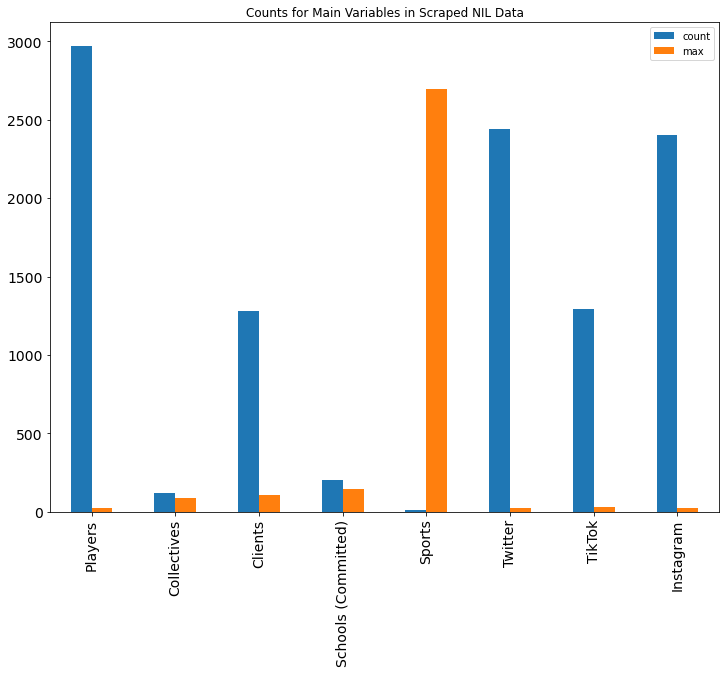

In [272]:
bigCounts = (summaryCountTable.iloc[[0,7], : ])
bigCountsTranspose = bigCounts.transpose()

#print(bigCountsTranspose)
contsBar = bigCountsTranspose.plot.bar(legend = True, title = "Counts for Main Variables in Scraped NIL Data", 
                                    figsize=(12, 9), xlabel = "", fontsize=14)

### Top Clients and Collectives

Verifiedink, a custom digital trading card company, was the most common client among NIL deals. Athletes looking for a prolific collective associated with their school might consider Texas Tech (https://www.matadorclub.org/), Oklahoma (https://crimsoncreamcollective.com/), or the University of Houston (https://www.linkingcoogs.com/), since these collectives were listed most often in this dataset.

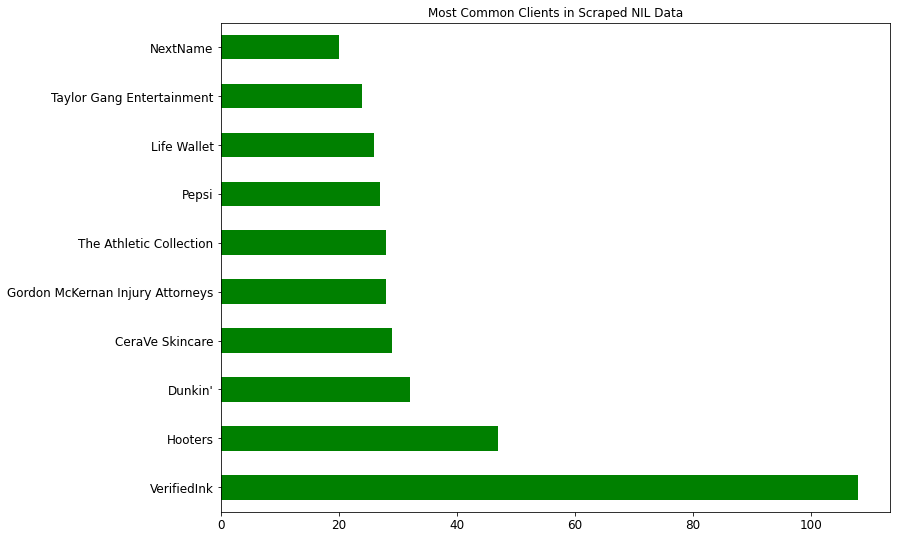

In [273]:
topClients = clientSummarySize.iloc[:10]
clientBar = topClients.plot.barh(legend = False, title = "Most Common Clients in Scraped NIL Data", color = "green", 
                                    figsize=(12, 9), fontsize=12, xlabel = "")

<div>
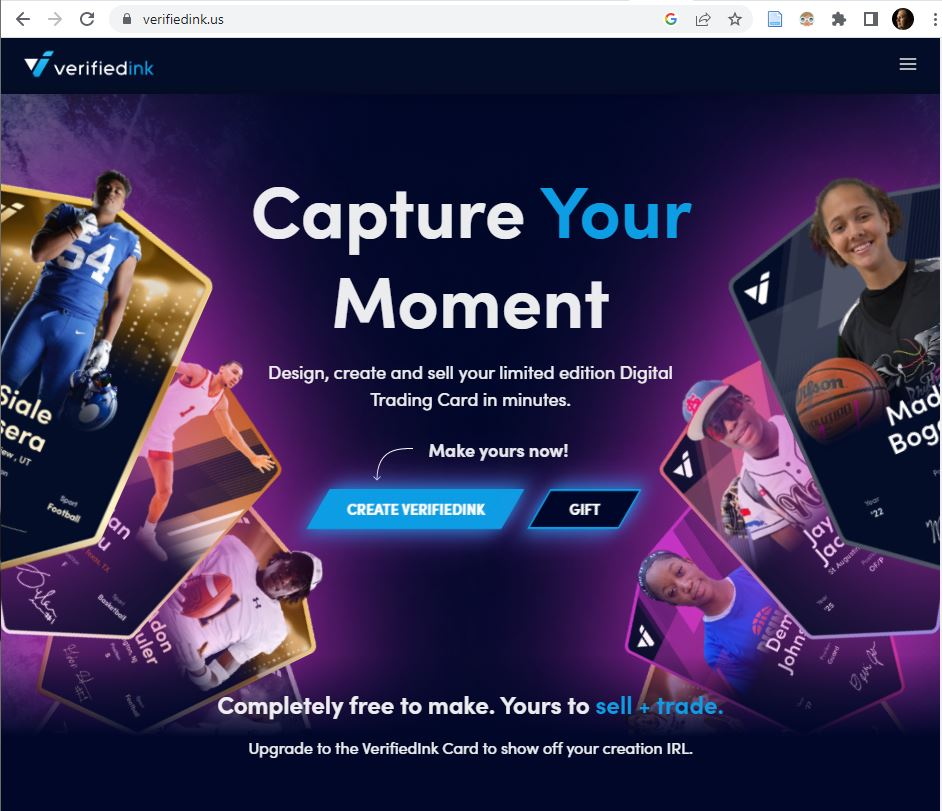
</div>

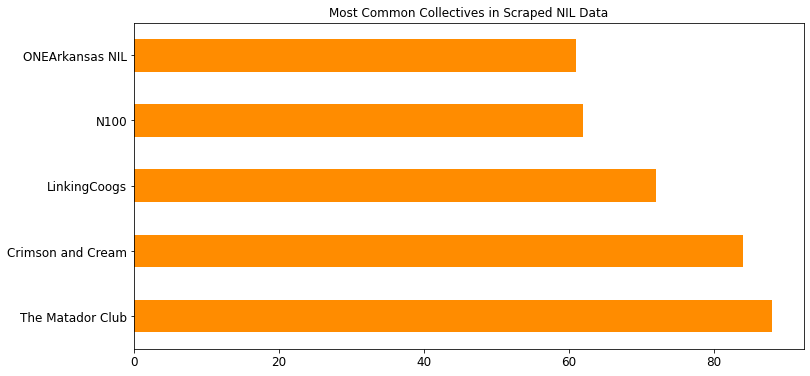

In [274]:
topCollectives = collectiveSummarySize.iloc[:5]
collectiveBar = topCollectives.plot.barh(legend = False, title = "Most Common Collectives in Scraped NIL Data", 
                                            color = "darkorange", figsize=(12, 6), fontsize=12, xlabel = "")

### Athletes with the most NIL deals

Angel Reese has the most NIL deals of any athlete in this dataset. This was also true for a smaller dataset that included closer to 2,500 athletes. The range of clients is interesting, ranging from investment brokers, to restaurants, to SI Swimsuit. This type of variety was consistent with Jordan Chiles, who had the second-most NIL deals ranging from Pottery Barn Teen to DoorDash.

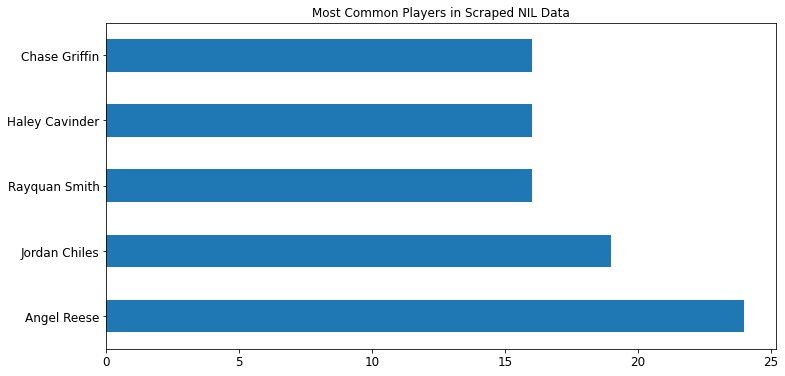

In [275]:
topPlayers = playerSummarySize.iloc[:5]
pBar = topPlayers.plot.barh(legend = False, title = "Most Common Players in Scraped NIL Data", 
                                                                  figsize=(12, 6), fontsize=12, xlabel = "")

In [276]:
AngelClients = summary.loc[summary['player'] == "Angel Reese"]
AngelClients[['client', 'collective']]

,client,collective
30,SI Swimsuit,NaN
57,Mercedes-Benz of Baton Rouge,Bayou Traditions
139,Caktus AI,NaN
211,Campus Ink,NaN
221,Raising Cane's,NaN
260,Intuit TurboTax,NaN
371,JanSport,NaN
445,Bose,NaN
512,Banter by Piercing Pagoda,NaN
525,Sonic,NaN


In [277]:
JordanClients = summary.loc[summary['player'] == "Jordan Chiles"]
JordanClients[['client', 'collective']]

,client,collective
372,Cash App,NaN
2887,Urban Outfitters,NaN
2888,Reebok,NaN
3080,Amazon,NaN
3156,SoFi,NaN
3730,Degree Deodorant,NaN
4291,Gymshark,NaN
4514,Levi's,NaN
4548,Pottery Barn Teen,NaN
4585,Cheetos,NaN


## Reflection and Next Steps

The results presented here represent 5,000 athlete records and nearly 3,000 unique athletes. The experience of scraping these data was satisfying (controlling a separate browser window with Selenium was irrationally satisfying for some reason) and educational. I believe the weakest component of the project was the extraction of information about the athletes' sport. I do believe this could be resolved with a bit more time and creativity. 

My primary concern in presenting a summary of results is the fact the the total size of the on3.com/nil/deals database is unknown. Of course, scraping the entire database is not necessary for a quality project, but it was clear from working with datasets of different sizes that the crude summaries (e.g., collectives with the most deals) presented in this report would change dramatically depending on the size of the dataset. I believe this concern could be alleviated somewhat by scraping information suitable for selecting or filtering the dataset for different time periods. For example, on the individual athlete pages, there are dates associated with the athlete's involvement with collectives and/or clients. Similarly, there is a container holding a "Class Year" variable. The ability to select certain time periods for analysis would give the results more context and an overall more concrete feel.

In terms of skills developed, I am fairly pleased with the results of this project. However, compared to examples in documentation and other websites, my navigation of the parsed html tree still feels a bit clunky. I could use more practice with functions such as "find_next_siblings()", list comprehensions and/or nested loops. Similarly, a function and/or loop would make for more compact code in the data summary cell just below the "Exploration of data in static data file" section. I look forward to developing these skills in future projects.